In [49]:
class AOD:
    def __init__(self, obj):
        self.obj = obj

    def __getattribute__(self, attribute):
        if attribute in ['__dict__','__class__','obj','__getattribute__'] :
            return object.__getattribute__(self, attribute)
        if attribute in self.__class__.__dict__:
            return object.__getattribute__(self, attribute)
        if attribute in self.__dict__:
            return object.__getattribute__(self, attribute)
        return self.obj.__getattribute__(attribute)

    def __setattr__(self, attribute, value):
        if attribute in ['obj'] :
            return object.__setattr__(self, attribute, value)
        return self.obj.__setattr__(attribute, value)
    
class CPP:
    def __init__(self, protecteds):
        self.__protecteds = protecteds
        
    def __getattribute__(self, attribute):
        if attribute in ['__getattribute__','_CPP__protecteds','__dict__']:
            return object.__getattribute__(self, attribute)
        if attribute in self.__protecteds:
            return object.__getattribute__(self, '_'+attribute)
        return object.__getattribute__(self, attribute)
        
    def __setattr__(self, attribute, value):
        if '_CPP__protecteds' in self.__dict__:
            if attribute in self.__protecteds:
                raise Exception(f'Can not modify constant property: {attribute}')
        return object.__setattr__(self, attribute, value)
    
    
class A(CPP):
    def __init__(self):
        CPP.__init__(self, protecteds=['az','z'])
        self._az = 12
        
class B(AOD, A):
    def __init__(self, obj):
        AOD.__init__(self, obj)
        self.axc = 25
        
a = B(A())
print(a.az)
a.t = 2
a.az += 1
a.obj.__dict__

12


Exception: Can not modify constant property: az

# neuron

In [1]:
from cnsproject.network.neural_populations import AELIFPopulation
n = AELIFPopulation('n1', (1,), dt=1)

In [2]:
from cnsproject.utils import generate_function
I = generate_function(250, shape=(1,),
           shift={0: 75, 150: 50},
           noise=10,
           population_noise=1)

In [3]:
from cnsproject.monitors.monitors import Monitor
m = Monitor(n, ['s','w','u'], time=250)
m.simulate(n.forward, inputs={'direct_input': I})

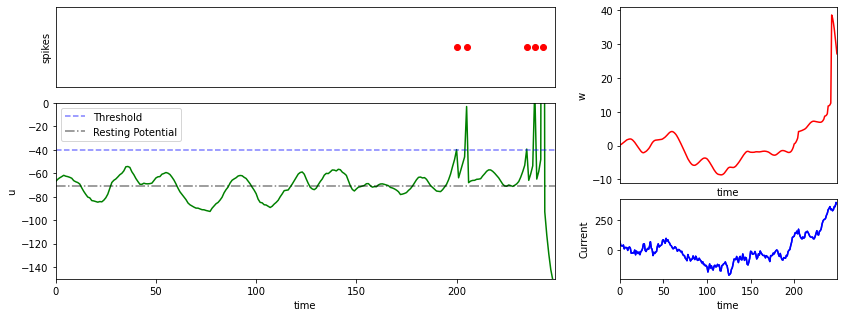

In [4]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,5))
p = Plotter([
    ['s','s','w'],
    ['u','u','w'],
    ['u','u','i'],
], wspace=0.3, monitor=m)
p.neuron_spike('s', x_vis=False)
p.neuron_voltage('u', y_lim=(-150,0))
p.current_dynamic('i', I=I)
p.adaptation_current_dynamic('w', x_vis=False)
p.show()

# neural_populations

In [5]:
from cnsproject.network.neural_populations import LIFPopulation
n = LIFPopulation('n1', (4,50), dt=1)

In [6]:
from cnsproject.utils import generate_function
I = generate_function(250, shape=(4,50),
           shift={0: 75, 150: 50},
           noise=10,
           population_noise=5)

In [7]:
from cnsproject.monitors.monitors import Monitor
m = Monitor(n, ['s'], time=250)
m.simulate(n.forward, inputs={'direct_input': I})

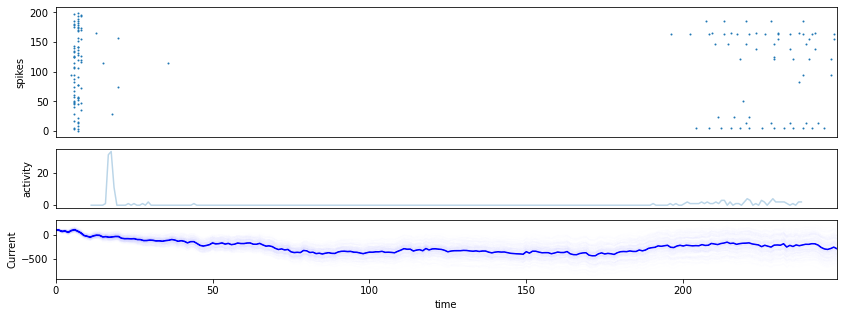

In [8]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,5))
p = Plotter([
    ['s'],
    ['s'],
    ['a'],
    ['i'],
], wspace=0.3, monitor=m)
p.population_activity_raster('s', x_vis=False)
p.population_activity('a', x_vis=False)
p.current_dynamic('i', I=I)
p.show()

# axon_set (and wrapper: USING, OF for axons)

In [9]:
import torch
import warnings
warnings.filterwarnings("ignore")

In [10]:
from cnsproject.network.neural_populations import LIFPopulation
n = LIFPopulation('n1', (2,), dt=1.)

In [11]:
from cnsproject.utils import generate_function
I = generate_function(2500, shape=(1,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

In [12]:
from cnsproject.network.axon_sets import SimpleAxonSet
n.add_axon(SimpleAxonSet('a0',
        terminal=(3,),
        delay=torch.tensor([0,20])
    ))

In [13]:
from cnsproject.network.axon_sets import SimpleAxonSet
n.use(SimpleAxonSet('a1',
        terminal=(2,),
        delay=torch.tensor([[0,20],[0,20]])
    ))

In [14]:
from cnsproject.network.axon_sets import SRFAxonSet
from cnsproject.network.network_wrapper import USING
n |USING| SRFAxonSet('a2',
        terminal=(2,), #terminal shape is 1 per each axon
        tau=torch.tensor([[7.,11.],[7.,11.]]),
        max_spikes_at_the_same_time=3,
    )

LIFPopulation(
  (a0): SimpleAxonSet()
  (a1): SimpleAxonSet()
  (a2): SRFAxonSet()
)

In [15]:
from cnsproject.network.axon_sets import SRFAxonSet
from cnsproject.network.network_wrapper import OF
SRFAxonSet('a3',
        terminal=(3,), #terminal shape is 1 per each axon
        delay=torch.tensor([[0,10,25]]),
        tau=9.,
        max_spikes_at_the_same_time=3,
    ) |OF| n

SRFAxonSet()

In [16]:
from cnsproject.network.axon_sets import SRFAxonSet
n |USING| SRFAxonSet('a4',
        terminal=(3,), #terminal shape is 1 per each axon
        delay=torch.tensor([0,20]),
        tau=torch.tensor([[7.,11.,20],[7.,11.,20]]),
        max_spikes_at_the_same_time=3,
    )

LIFPopulation(
  (a0): SimpleAxonSet()
  (a1): SimpleAxonSet()
  (a2): SRFAxonSet()
  (a3): SRFAxonSet()
  (a4): SRFAxonSet()
)

In [17]:
from cnsproject.monitors.monitors import Monitor
n.reset()
m = Monitor(n, state_variables=['s','u'], state_calls={
    'a0': n.axons['a0'].neurotransmitters,
    'a1': n.axons['a1'].neurotransmitters,
    'a2': n.axons['a2'].neurotransmitters,
    'a3': n.axons['a3'].neurotransmitters,
    'a4': n.axons['a4'].neurotransmitters,
}, time=250)
m.simulate(n.forward, inputs={'direct_input': I})

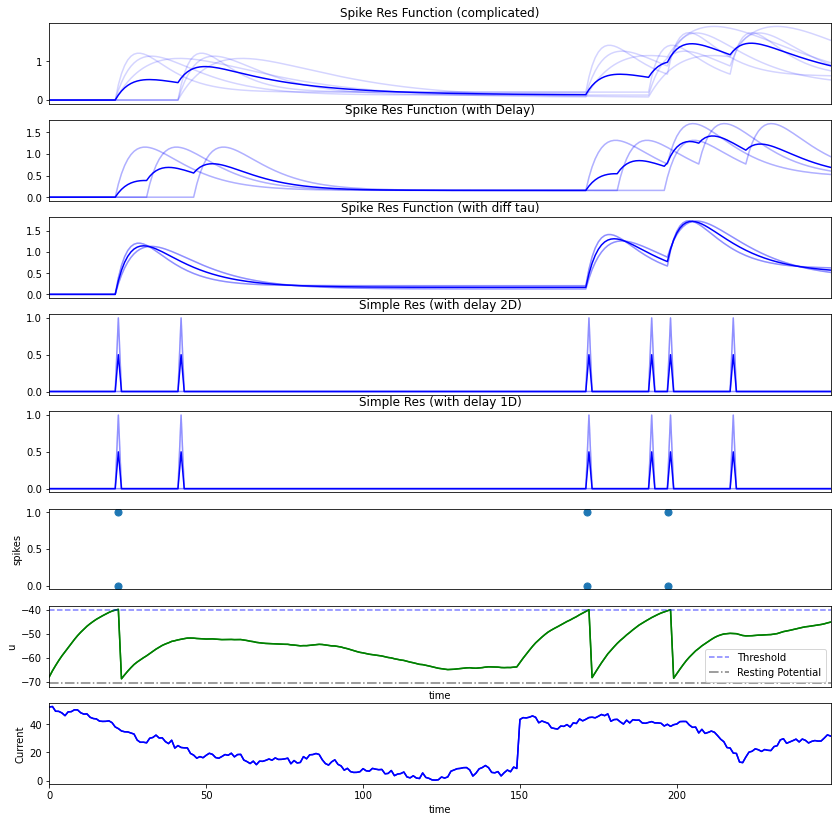

In [18]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,14))
p = Plotter([
    ['a4'],
    ['a3'],
    ['a2'],
    ['a1'],
    ['a0'],
    ['s'],
    ['u'],
    ['i'],
], wspace=0.3, monitor=m)
p.current_dynamic('i', I=I[:250])
p.neuron_voltage('u', x_vis=False)
p.population_activity_raster('s', x_vis=False, s=50)
p.population_plot('a0', y='a0', x_vis=False, title="Simple Res (with delay 1D)", x_lim='fit')
p.population_plot('a1', y='a1', x_vis=False, title="Simple Res (with delay 2D)", x_lim='fit')
p.population_plot('a2', y='a2', x_vis=False, title="Spike Res Function (with diff tau)", x_lim='fit')
p.population_plot('a3', y='a3', x_vis=False, title="Spike Res Function (with Delay)", x_lim='fit')
p.population_plot('a4', y='a4', x_vis=False, title="Spike Res Function (complicated)", x_lim='fit')
p.show()

Also works well in multi dims and multo terminals.

# dendrite_set (and wrapper: USING, OF for axons)

In [19]:
import torch
import warnings
warnings.filterwarnings("ignore")

In [20]:
from cnsproject.utils import generate_function
I = generate_function(250, shape=(10,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

In [21]:
from cnsproject.network.neural_populations import LIFPopulation
n1 = LIFPopulation('n1', (10,), dt=1.)
n2 = LIFPopulation('n2', (1,), dt=1.)

In [22]:
from cnsproject.network.axon_sets import SimpleAxonSet,SRFAxonSet

from cnsproject.network.network_wrapper import USING
from cnsproject.network.network_wrapper import OF
######################################################3 Axons without name
n1 |USING| SimpleAxonSet(terminal=(2,2))
SRFAxonSet(scale=2., max_spikes_at_the_same_time=3) |OF| n1

SRFAxonSet()

In [23]:
from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.weight_initializations import norm_initialization,uniform_initialization

n2 |USING| SimpleDendriteSet('d1',
    terminal=(10,2,2),
    w=norm_initialization(w_mean=.5, w_std=.1),
)

w = torch.zeros(10,1)
w[4:6,0] = 5
SimpleDendriteSet(
    terminal=(10,),
    wmax=5.,
    w=lambda a,b: w,
) |OF| n2

SimpleDendriteSet()

In [24]:
from cnsproject.monitors.monitors import Monitor
n1.reset()
n2.reset()
mn1 = Monitor(n1, ['s'], {
    'a1': n1.axons['n1_axon_0'].neurotransmitters,
    'a2': n1.axons['n1_axon_1'].neurotransmitters,
}, time=250)
mn2 = Monitor(n2, ['u'])
md1 = Monitor(n2.dendrites['d1'], ['I'])
md2 = Monitor(n2.dendrites['n2_dendrite_1'], ['I'])

In [25]:
def run(direct_input): # instead of network (for testing step by step)
    n2.dendrites['d1'].forward(n1.axons['n1_axon_0'].neurotransmitters())
    n2.dendrites['n2_dendrite_1'].forward(n1.axons['n1_axon_1'].neurotransmitters())
    n1.forward(direct_input=direct_input)
    n2.forward()
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2, md1, md2])

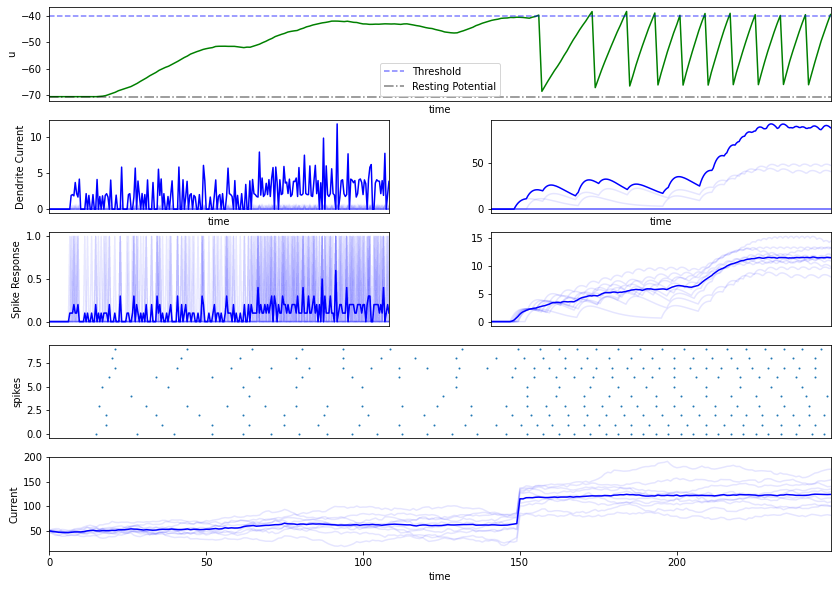

In [26]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,10))
p = Plotter([
    ['u','u'],
    ['d1','d2'],
    ['a1','a2'],
    ['s','s'],
    ['i','i'],
], wspace=0.3, monitor=mn1)
p.current_dynamic('i', I=I)
p.population_activity_raster('s', x_vis=False)
p.spike_response_function('a1', y='a1', x_vis=False)
p.spike_response_function('a2', y='a2', x_vis=False, y_label='')
p.dendrite_current('d1', x_vis=False, y_label="Dendrite Current", monitor=md1)
p.dendrite_current('d2', x_vis=False, y_label='', monitor=md2)
p.neuron_voltage('u', x_vis=False, monitor=mn2)
p.show()

Dendrite response to nan values is right

In [30]:
import torch
import warnings
warnings.filterwarnings("ignore")

from cnsproject.utils import generate_function
I = generate_function(250, shape=(10,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

from cnsproject.network.neural_populations import LIFPopulation
n1 = LIFPopulation('n1', (10,), dt=1.)
n2 = LIFPopulation('n2', (1,), dt=1.)

from cnsproject.network.axon_sets import SimpleAxonSet,SRFAxonSet

from cnsproject.network.network_wrapper import USING
from cnsproject.network.network_wrapper import OF
######################################################3 Axons without name
n1 |USING| SimpleAxonSet(terminal=(2,2))
SRFAxonSet(scale=2., max_spikes_at_the_same_time=3) |OF| n1

from cnsproject.network.dendrite_sets import NanBlockerDendriteSet
from cnsproject.network.weight_initializations import norm_initialization,uniform_initialization

n2 |USING| NanBlockerDendriteSet('d1',
    terminal=(10,2,2),
    w=norm_initialization(w_mean=.5, w_std=.1),
)

w = torch.zeros(10,1)
w[4:6,0] = 5
NanBlockerDendriteSet(
    terminal=(10,),
    wmax=5.,
    w=lambda a,b: w,
) |OF| n2

from cnsproject.monitors.monitors import Monitor
n1.reset()
n2.reset()
mn1 = Monitor(n1, ['s'], {
    'a1': n1.axons['n1_axon_0'].neurotransmitters,
    'a2': n1.axons['n1_axon_1'].neurotransmitters,
}, time=250)
mn2 = Monitor(n2, ['u'])
md1 = Monitor(n2.dendrites['d1'], ['I'])
md2 = Monitor(n2.dendrites['n2_dendrite_1'], ['I'])

In [31]:
from cnsproject.monitors.monitors import Monitor
n1.reset()
n2.reset()

z = 0
def run(direct_input): # instead of network (for testing step by step)
    global z
    n2.dendrites['d1'].forward(n1.axons['n1_axon_0'].neurotransmitters())
    z += 1
    if z > 100:
        temp = n1.axons['n1_axon_1'].neurotransmitters()
        temp[:temp.shape[0]//2] = float("nan")
        n2.dendrites['n2_dendrite_1'].forward(temp)
    else:
        n2.dendrites['n2_dendrite_1'].forward(n1.axons['n1_axon_1'].neurotransmitters())
    n1.forward(direct_input=direct_input)
    n2.forward()
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2,md1,md2])

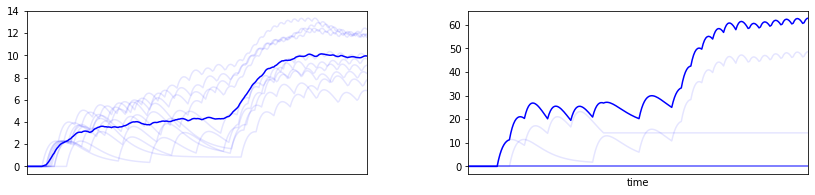

In [32]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,3))
p = Plotter([
    ['a2','d2'],
], wspace=0.3)
p.spike_response_function('a2', y='a2', x_vis=False, y_label='', monitor=mn1)
p.dendrite_current('d2', x_vis=False, y_label='', monitor=md2)
p.show()

Also works well in multi dims and multo terminals.

In [33]:
from cnsproject.network.neural_populations import LIFPopulation
n1 = LIFPopulation('n1', (10,), dt=1.)
n2 = LIFPopulation('n2', (10,10), dt=1.)

from cnsproject.network.axon_sets import SimpleAxonSet
a1 = SimpleAxonSet('a1',
    population=(10,),
    terminal=(2,),
    scale=5.,
)
n1.add_axon(a1)

from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.weight_initializations import norm_initialization
d1 = SimpleDendriteSet('d1',
    terminal=(10,2),
    population=(10,10),
    wmax=10.,
    w=norm_initialization(w_mean=5., w_std=1.),
)
n2.use(d1)

from cnsproject.monitors.monitors import Monitor
n1.reset()
n2.reset()
mn1 = Monitor(n1, ['s'], time=250)
ma1 = Monitor(a1, ['e'])
md1 = Monitor(d1, ['I'])
mn2 = Monitor(n2, ['s'])

In [34]:
from cnsproject.utils import generate_function
I = generate_function(250, shape=(10,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

def run(direct_input): # instead of network (for testing step by step)
    d1.forward(a1.neurotransmitters())
    n1.forward(direct_input=direct_input)
    n2.forward()
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2,ma1,md1])

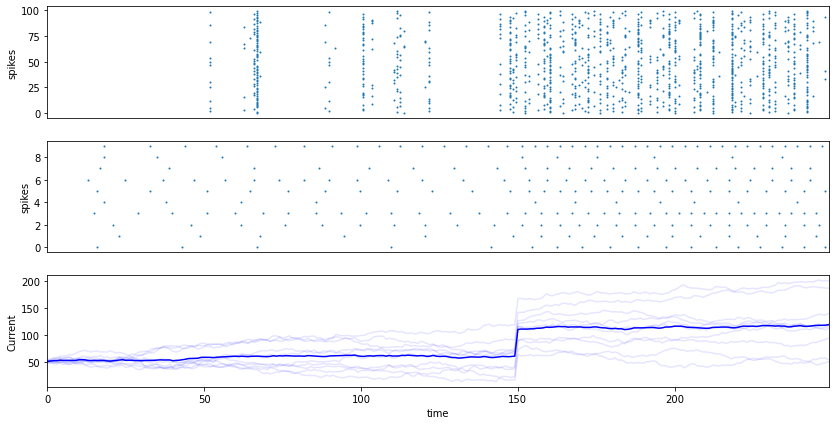

In [35]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,7))
p = Plotter([
    ['s2'],
    ['s1'],
    ['i'],
], wspace=0.3)
p.current_dynamic('i', I=I)
p.population_activity_raster('s1', y='s', x_vis=False, monitor=mn1)
p.population_activity_raster('s2', y='s', x_vis=False, monitor=mn2)
p.show()

# synapse_set (and wrapper: FROM, TO)

In [36]:
import torch
import warnings
warnings.filterwarnings("ignore")
from cnsproject.network.network_wrapper import USING, OF, FROM, TO

from cnsproject.network.neural_populations import LIFPopulation
n1 = LIFPopulation('n1', (10,), dt=1.)
n2 = LIFPopulation('n2', (10,10), dt=1.)

from cnsproject.network.axon_sets import SimpleAxonSet
n1 |USING| SimpleAxonSet('a1',
    terminal=(2,),
    scale=5.,
)

from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.weight_initializations import norm_initialization
n2 |USING| SimpleDendriteSet('d1',
    wmax=10.,
    w=norm_initialization(w_mean=5., w_std=1.),
)

from cnsproject.monitors.monitors import Monitor
n1.reset()
n2.reset()
mn1 = Monitor(n1, ['s'], time=250)
ma1 = Monitor(n1.axons['a1'], ['e'])
md1 = Monitor(n2.dendrites['d1'], ['I'])
mn2 = Monitor(n2, ['s'])

from cnsproject.utils import generate_function
import torch
I = generate_function(250, shape=(10,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

In [39]:
from cnsproject.network.synapse_sets import SimpleSynapseSet
from cnsproject.network.connectivity_patterns import rfpopp_connectivity

s1 = SimpleSynapseSet(
    dt = 1.,
    connectivity = rfpopp_connectivity(c_rate=.8)
) |FROM| n1.axons['a1'] |TO| n2.dendrites['d1']
s1.reset()

In [40]:
# from cnsproject.network.synapse_sets import SimpleSynapseSet
# from cnsproject.network.connectivity_patterns import rfnopp_connectivity

# s1 = SimpleSynapseSet(
#     dt = 1.,
#     connectivity = rfnopp_connectivity(c_rate=.8)
# ) |TO| n2.dendrites['d1']
# s1 |FROM| n1.axons['a1']
# s1.reset()

In [41]:
def run(direct_input): # instead of network (for testing step by step)
    s1.forward()
    n1.forward(direct_input=direct_input)
    n2.forward()
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2,ma1,md1])

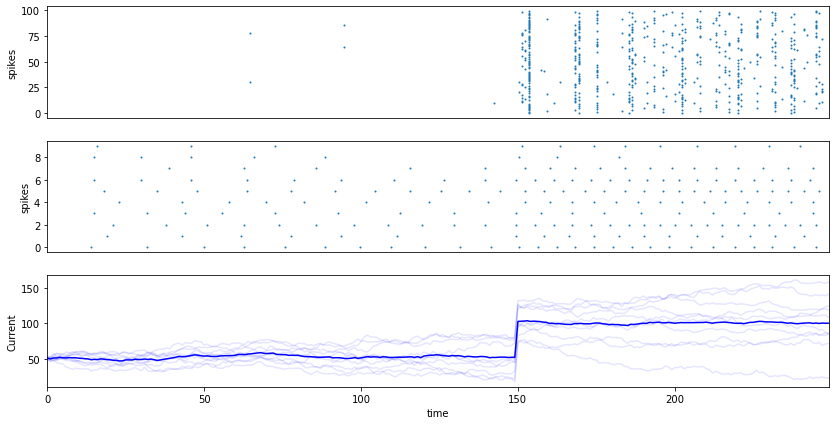

In [42]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,7))
p = Plotter([
    ['s2'],
    ['s1'],
    ['i'],
], wspace=0.3)
p.current_dynamic('i', I=I)
p.population_activity_raster('s1', y='s', x_vis=False, monitor=mn1)
p.population_activity_raster('s2', y='s', x_vis=False, monitor=mn2)
p.show()

Connection can be not fully described!

In [43]:
import torch
import warnings
warnings.filterwarnings("ignore")

from cnsproject.network.neural_populations import LIFPopulation
n1 = LIFPopulation('n1', (2,), dt=1.)
n2 = LIFPopulation('n2', (3,3), dt=1.)

from cnsproject.network.axon_sets import SRFAxonSet
a1 = SRFAxonSet('a1',
    population=(2,),
    terminal=(2,),
    scale=25.,
    delay=(torch.rand(2,2)*20),
    tau=(5+torch.rand(2,2)*10),
)
a1 |OF| n1

from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.weight_initializations import norm_initialization
d1 = SimpleDendriteSet('d1',
    terminal=(1,3),
    wmax=10.,
    w=norm_initialization(w_mean=5., w_std=1.),
)
d1 |OF| n2

from cnsproject.monitors.monitors import Monitor
n1.reset()
n2.reset()
mn1 = Monitor(n1, ['s'], time=250)
ma1 = Monitor(a1, ['e'])
md1 = Monitor(d1, ['I'])
mn2 = Monitor(n2, ['s'])

from cnsproject.utils import generate_function
import torch
I = generate_function(250, shape=(2,),
           shift={0: 50, 150: 50},
           noise=.1,
           population_noise=1)
I = torch.abs(I)

from cnsproject.network.synapse_sets import FilterSynapseSet
passage = torch.tensor([
    [[
        [True, False, True],
        [False, True, True],
        [True, True, False],
    ],[
        [True, True, False],
        [True, True, True],
        [True, False, True],
    ]]
])

s1 = FilterSynapseSet(
    dt = 1.,
    passage = passage,
    axon_passage = [[1],True],
    dendrite_terminal_passage = [True,[0,2]]
)
s1 |FROM| a1 |TO| d1

FilterSynapseSet(
  (axon): SRFAxonSet()
  (dendrite): SimpleDendriteSet()
)

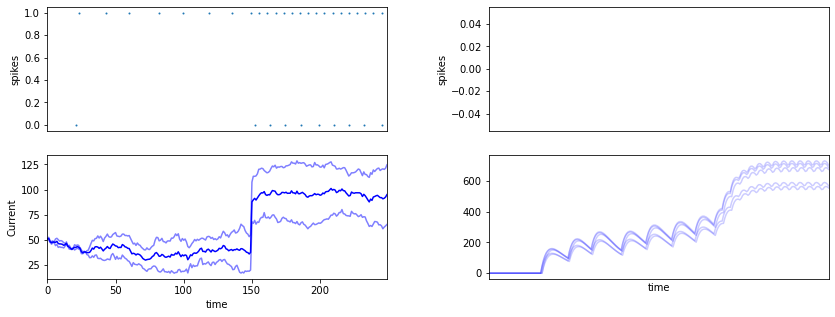

In [44]:
def run(direct_input): # instead of network (for testing step by step)
    s1.forward()
    n1.forward(direct_input=direct_input)
    n2.forward()
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2,ma1,md1])

import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,5))
p = Plotter([
    ['s1','s2'],
    ['i','d2'],
], wspace=0.3)
p.current_dynamic('i', I=I)
p.dendrite_current('d2', x_vis=False, y_label='', monitor=md1, population_alpha=.2)
p.population_activity_raster('s1', y='s', x_vis=False, monitor=mn1)
p.population_activity_raster('s2', y='s', x_vis=False, monitor=mn2)
p.show()

# network

In [45]:
import warnings
warnings.filterwarnings("ignore")
import torch

from cnsproject.network.network import Network
from cnsproject.network.neural_populations import LIFPopulation as Lif
from cnsproject.network.axon_sets import SimpleAxonSet as Axon
from cnsproject.network.dendrite_sets import SimpleDendriteSet as Dendrite
from cnsproject.network.synapse_sets import SimpleSynapseSet as Synapse
from cnsproject.network.weight_initializations import norm_initialization as norm_w
from cnsproject.network.connectivity_patterns import rfpopp_connectivity as rfpopp
from cnsproject.network.network_wrapper import *

In [46]:
net = Network(dt=1.)
net += Lif("n1", (4 ,50))
net += Lif("n2", (4 ,50))
net += Lif("n3", (12,2 ))
net += Synapse(connectivity=rfpopp(.2, internal=True)) \
    |FROM| (Axon(scale=2) |OF| net['n1']) |TO| (Dendrite(w=norm_w()) |OF| net['n1'])
net += Synapse(connectivity=rfpopp(.2, internal=True)) \
    |FROM| (Axon(scale=2) |OF| net['n2']) |TO| (Dendrite(w=norm_w()) |OF| net['n2'])
net += Synapse(connectivity=rfpopp(.8)) \
    |FROM| (Axon(scale=20) |OF| net['n1']) |TO| (Dendrite(w=norm_w()) |OF| net['n3'])
net += Synapse(connectivity=rfpopp(.8)) \
    |FROM| (Axon(scale=20) |OF| net['n2']) |TO| (Dendrite(w=norm_w()) |OF| net['n3'])
net += Synapse(connectivity=rfpopp(.8)) \
    |FROM| (Axon(scale=20, is_excitatory=False) |OF| net['n3']) |TO| (Dendrite(w=norm_w()) |OF| net['n1'])
net += Synapse(connectivity=rfpopp(.8)) \
    |FROM| (Axon(scale=20, is_excitatory=False) |OF| net['n3']) |TO| (Dendrite(w=norm_w()) |OF| net['n2'])
print(net)

======================================== Neural Populations:
n1_dendrite_0, n1_dendrite_1 [n1] n1_axon_0, n1_axon_1
n2_dendrite_0, n2_dendrite_1 [n2] n2_axon_0, n2_axon_1
n3_dendrite_0, n3_dendrite_1 [n3] n3_axon_0, n3_axon_1
======================================== Synapse Sets:
n1_axon_0 -> n1_axon_0-n1_dendrite_0 -> n1_dendrite_0
n2_axon_0 -> n2_axon_0-n2_dendrite_0 -> n2_dendrite_0
n1_axon_1 -> n1_axon_1-n3_dendrite_0 -> n3_dendrite_0
n2_axon_1 -> n2_axon_1-n3_dendrite_1 -> n3_dendrite_1
n3_axon_0 -> n3_axon_0-n1_dendrite_1 -> n1_dendrite_1
n3_axon_1 -> n3_axon_1-n2_dendrite_1 -> n2_dendrite_1
======================================== Learning Rule Enforcers:
======================================== Neuromodulatory Tissues:



In [17]:
# main_loop:
for i in range(10):
    for j in range(10):
        for k in range(10):
            if k==3 and j==2:
                break 2
print(i,j,k)

SyntaxError: invalid syntax (<ipython-input-17-4b43c7783529>, line 6)

In [ ]:
for i, j in np.ndindex(n, n):
  val = x[i, j]
  break

In [47]:
n1 = LIFPopulation((4 ,50))
n2 = LIFPopulation((4 ,50))
n3 = LIFPopulation((12,2 ))
a1_1 = SimpleAxonSet(population=n1.shape, scale=2)
a2_2 = SimpleAxonSet(population=n2.shape, scale=2)
a1_3 = SimpleAxonSet(population=n1.shape, scale=20)
a3_1 = SimpleAxonSet(population=n3.shape, scale=20, is_excitatory=False)
a2_3 = SimpleAxonSet(population=n2.shape, scale=20)
a3_2 = SimpleAxonSet(population=n3.shape, scale=20, is_excitatory=False)
n1.add_axon_set(a1_1, 'a1_1')
n1.add_axon_set(a1_3, 'a1_3')
n2.add_axon_set(a2_2, 'a2_2')
n2.add_axon_set(a2_3, 'a2_3')
n3.add_axon_set(a3_1, 'a3_1')
n3.add_axon_set(a3_2, 'a3_2')
d1_1 = SimpleDendriteSet(terminal=n1.shape, population=n1.shape, w=norm_initialization(n1.shape,n1.shape))
d2_2 = SimpleDendriteSet(terminal=n2.shape, population=n2.shape, w=norm_initialization(n2.shape,n2.shape))
d1_3 = SimpleDendriteSet(terminal=n1.shape, population=n3.shape, w=norm_initialization(n1.shape,n3.shape))
d3_1 = SimpleDendriteSet(terminal=n3.shape, population=n1.shape, w=norm_initialization(n3.shape,n1.shape))
d2_3 = SimpleDendriteSet(terminal=n2.shape, population=n3.shape, w=norm_initialization(n2.shape,n3.shape))
d3_2 = SimpleDendriteSet(terminal=n3.shape, population=n2.shape, w=norm_initialization(n3.shape,n2.shape))
n1.add_dendrite_sets(d1_1, 'd1_1')
n1.add_dendrite_sets(d3_1, 'd3_1')
n2.add_dendrite_sets(d2_2, 'd2_2')
n2.add_dendrite_sets(d3_2, 'd3_2')
n3.add_dendrite_sets(d1_3, 'd1_3')
n3.add_dendrite_sets(d2_3, 'd2_3')
s1_1 = SimpleSynapseSet(axon_set=a1_1, dendrite_set=d1_1, connectivity=in_rfnopp_connectivity(n1.shape, c_rate=.2))
s2_2 = SimpleSynapseSet(axon_set=a2_2, dendrite_set=d2_2, connectivity=in_rfnopp_connectivity(n2.shape, c_rate=.2))
s1_3 = SimpleSynapseSet(axon_set=a1_3, dendrite_set=d1_3, connectivity=rfnopp_connectivity(n1.shape,n3.shape, c_rate=.8))
s3_1 = SimpleSynapseSet(axon_set=a3_1, dendrite_set=d3_1, connectivity=rfnopp_connectivity(n3.shape,n1.shape, c_rate=.8))
s2_3 = SimpleSynapseSet(axon_set=a2_3, dendrite_set=d2_3, connectivity=rfnopp_connectivity(n2.shape,n3.shape, c_rate=.8))
s3_2 = SimpleSynapseSet(axon_set=a3_2, dendrite_set=d3_2, connectivity=rfnopp_connectivity(n3.shape,n2.shape, c_rate=.8))
net = Network(dt=1.)
net.add_population(n1, 'n1')
net.add_population(n2, 'n2')
net.add_population(n3, 'n3')
net.add_synapse(s1_1, 's1_1')
net.add_synapse(s2_2, 's2_2')
net.add_synapse(s1_3, 's1_3')
net.add_synapse(s3_1, 's3_1')
net.add_synapse(s2_3, 's2_3')
net.add_synapse(s3_2, 's3_2')

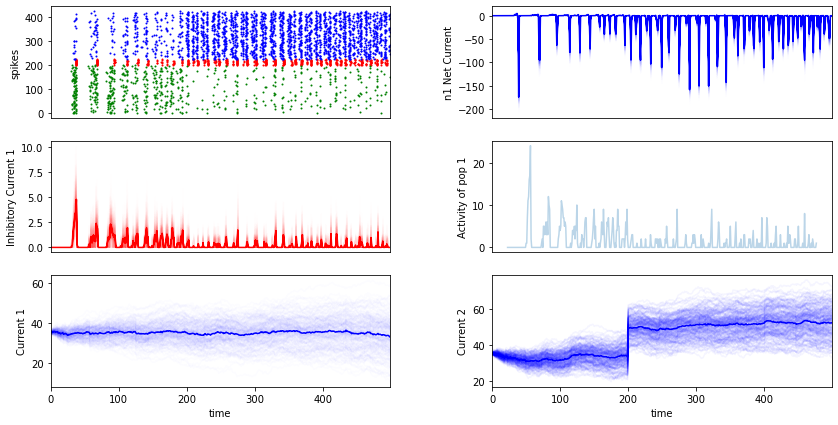

In [48]:
import matplotlib.pyplot as plt
from cnsproject.monitors.monitors import Monitor
from cnsproject.monitors.plotter import Plotter
from cnsproject.utils import generate_function

mn1 = Monitor(net['n1'], ['s'])
mn2 = Monitor(net['n2'], ['s'])
mn3 = Monitor(net['n3'], ['s'])
m = Monitor(net, state_calls={
    'i3_1': net['n1'].dendrites['n1_dendrite_0'].currents,
    'cI': net['n1'].collect_I,
}, time=500)

I1 = torch.abs(generate_function(500, shape=net['n1'].shape, shift={0: 35}, noise=.1, population_noise=.2))
I2 = torch.abs(generate_function(500, shape=net['n2'].shape, shift={0: 35, 200: 15}, noise=.1, population_noise=.2))

net.reset()
m.simulate(net.forward, inputs={'n1_direct_input': I1, 'n2_direct_input': I2},
             attendance=[mn1,mn2,mn3])

plt.figure(figsize=(14,7))
p = Plotter([
    ['s','ci'],
    ['e1','a1'],
    ['i1','i2'],
], wspace=0.3)
p.current_dynamic('i1', I=I1, y_label="Current 1", population_alpha=.01)
p.current_dynamic('i2', I=I2, y_label="Current 2", population_alpha=.04)
p.current_dynamic('e1', y='i3_1', y_label="Inhibitory Current 1", monitor=m, color='r', x_vis=False, x_label='')
p.current_dynamic('ci', y='cI', y_label="n1 Net Current", monitor=m, x_vis=False, x_label='')
p.population_activity('a1', y_label="Activity of pop 1", monitor=mn1, x_vis=False, x_label='')
p.population_activity_raster('s', monitor=mn3, color='r', start=net['n1'].s.numel(), x_vis=False, x_label='')
p.population_activity_raster('s', monitor=mn1, color='g', additive=True)
p.population_activity_raster('s', monitor=mn2, color='b', additive=True, start=net['n1'].s.numel()+net['n3'].s.numel())
p.show()

# encoder

In [49]:
import torch
import warnings
warnings.filterwarnings("ignore")

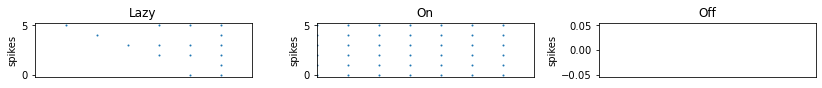

In [50]:
from cnsproject.network.encoders import LazyEncoder,AlwaysOnEncoder,AlwaysOffEncoder

n1 = LazyEncoder('n1', (2,3), dt=1)
n2 = AlwaysOnEncoder('n2', (2,3), dt=1)
n3 = AlwaysOffEncoder('n3', (2,3), dt=1)

from cnsproject.monitors.monitors import Monitor

mn1 = Monitor(n1, ['s'], time=7)
mn2 = Monitor(n2, ['s'])
mn3 = Monitor(n3, ['s'])

def run(direct_input): # instead of network (for testing step by step)
    n1.forward(direct_input=direct_input)
    n2.forward(direct_input=direct_input)
    n3.forward(direct_input=direct_input)
    
I = torch.tensor([
    [[False,False,False],[False,False,False]],
    [[False,False,False],[False,False,True]],
    [[False,False,False],[False,True,False]],
    [[False,False,False],[True,False,False]],
    [[False,False,True],[True,False,True]],
    [[True,False,True],[True,False,True]],
    [[True,True,True],[True,True,True]],
])
    
mn1.simulate(run, inputs={'direct_input': I},
             attendance=[mn2,mn3])

import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,1))
p = Plotter([
    ['s1','s2','s3'],
], wspace=0.3)
p.population_activity_raster('s1', y='s', title="Lazy", x_vis=False, monitor=mn1)
p.population_activity_raster('s2', y='s', title="On", x_vis=False, monitor=mn2)
p.population_activity_raster('s3', y='s', title="Off", x_vis=False, monitor=mn3)
p.show()

In [54]:
from cnsproject.network.encoders import *
from cnsproject.monitors.monitors import Monitor
from cnsproject.monitors.plotter import Plotter
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings("ignore")
from matplotlib import image
from PIL import Image
import numpy as np

path1 = "image1.jpg"
path2 = "image2.jpeg"
path3 = "image3.jpg"

time = 20
def t2fs_encodding_check(p, im, time=time, postfix='', dt=1, name=''):
    enc = Time2FirstSpikeEncoder(name='enc', shape=im.shape, max_input=255, time=time, dt=dt)
    enc.encode(torch.from_numpy(im))
    enc_monitor = Monitor(enc, state_variables=["s"], time=time, dt=dt)
    enc_monitor.reset()
    enc_monitor.simulate(enc.forward, {})
    p.population_activity_raster('st'+postfix, monitor=enc_monitor, y_label='spikes', x_label='time',
                                 s=7, alpha=.05)
    p.imshow('it'+postfix, enc.decode(enc_monitor['s']), cmap='YlGn', interpolation='nearest', title=name)
    return enc_monitor
    
def poisson_encodding_check(p, im, time=time, postfix='', dt=1, name='', max_rate=time):
    enc = PoissonEncoder(name='enc', shape=im.shape, max_input=255, rate=max_rate/time)
    enc.encode(torch.from_numpy(im))
    enc_monitor = Monitor(enc, state_variables=["s"], time=time, dt=dt)
    enc_monitor.reset()
    enc_monitor.simulate(enc.forward, {})
    data = p.population_activity_raster('sp'+postfix, monitor=enc_monitor, y_label='spikes', x_label='time',
                                 s=7, alpha=.02)
    p.imshow('ip'+postfix, enc.decode(enc_monitor['s']), cmap='YlGn', interpolation='nearest', title=name)
    return enc_monitor
    
def position_encodding_check(p, im, time=time, postfix='', dt=1, name='', k=10, mean=None, std=None):
    enc = PositionEncoder(name='enc', shape=im.shape, max_input=255, time=time, dt=dt, k=k, mean=mean, std=std)
    enc.encode(torch.from_numpy(im))
    enc_monitor = Monitor(enc, state_variables=["s",'stage'], time=time, dt=dt)
    enc_monitor.reset()
    enc_monitor.simulate(enc.forward, {})
    data = p.population_activity_raster('sn'+postfix, monitor=enc_monitor, y_label='spikes', x_label='time',
                                 s=7, alpha=.05)
    p.imshow('in'+postfix, enc.decode(enc_monitor['s']), cmap='YlGn', interpolation='nearest', title=name)
    return enc_monitor
    
def raster_3d(subplot, monitor, shape, reduction=1, s=1, x_r=False, y_r=False, z_r=False, **args):
    d = monitor['s']
    d = d.reshape(d.shape[0],-1)
    xe,ye = np.where(d)
    ax = plt.subplot(subplot, projection='3d')
    ye = np.array(ye)
    ye = ye//reduction
    xd = (np.array(ye)//shape[0])
    yd = (np.array(ye)%shape[1])
    zd = np.array(xe)
    ax.scatter(xd, yd, zd, s=s, **args)
    axes = ax.axes
    if x_r:
        axes.invert_xaxis()
    if z_r:
        axes.invert_zaxis()
    if y_r:
        axes.invert_yaxis()
    ax.set_zlabel("time")

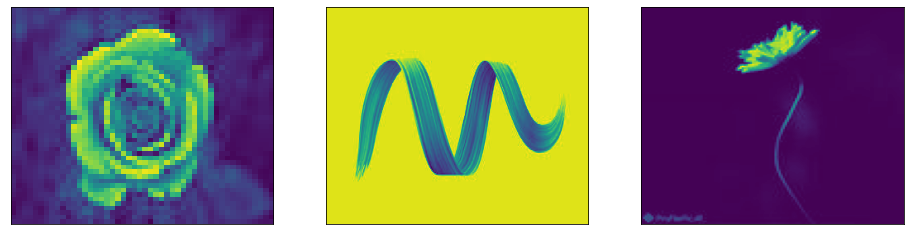

In [55]:
plt.figure(figsize=(16,4))
p = Plotter([
    ['im1','im2', 'im3'],
])
im1 = np.array(Image.open(path1).convert('L'))
gr_im1= Image.fromarray(im1)
p.imshow('im1', gr_im1)

im2 = np.array(Image.open(path2).convert('L'))
gr_im2= Image.fromarray(im2)
p.imshow('im2', gr_im2)

im3 = np.array(Image.open(path3).convert('L'))
gr_im3= Image.fromarray(im3)
p.imshow('im3', gr_im3)

plt.show()

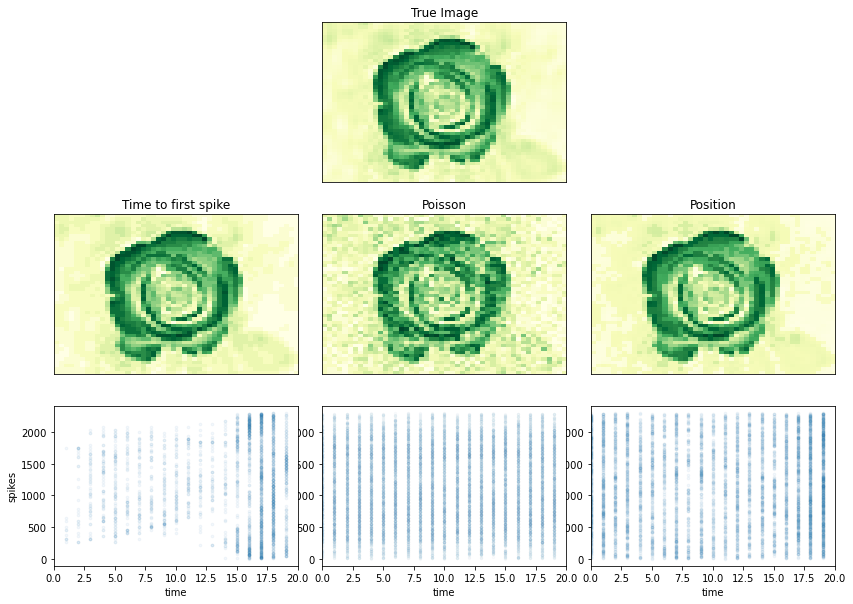

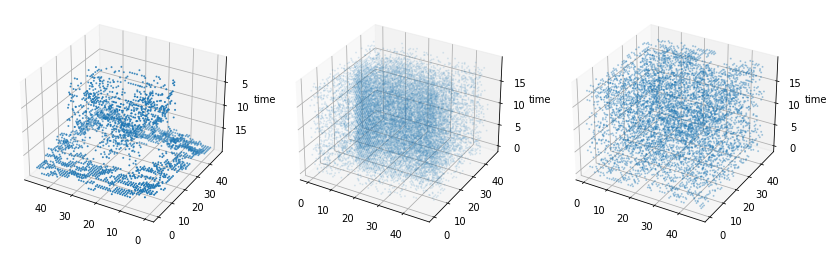

In [56]:
plt.figure(figsize=(14,10))
p = Plotter([
    [None, 'i',None],
    ['it','ip','in'],
    ['st','sp','sn'],
], wspace=0.1, hspace=0.2)

p.imshow('i', im1, title="True Image", cmap='YlGn', interpolation='nearest')
d1 = t2fs_encodding_check(p,im1,name='Time to first spike')
d2 = poisson_encodding_check(p,im1,name='Poisson')
d3 = position_encodding_check(p,im1,name='Position')
p.show()

plt.figure(figsize=(14,5))
raster_3d('131', d1, im1.shape, y_r=True, z_r=True)
raster_3d('132', d2, im1.shape, alpha=.1)
raster_3d('133', d3, im1.shape, reduction=10, alpha=.3)
plt.show()

# Learning

Unsupervised

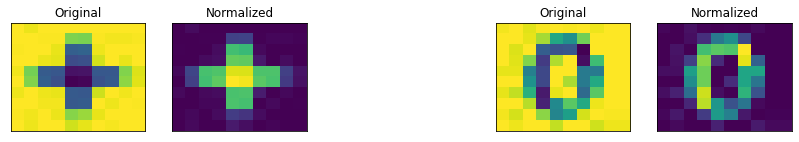

In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import matplotlib.pyplot as plt
from cnsproject.network.network import Network
from cnsproject.network.network_wrapper import *
from cnsproject.network.neural_populations import LIFPopulation
from cnsproject.network.encoders import PoissonEncoder
from cnsproject.network.axon_sets import SimpleAxonSet
from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.synapse_sets import SimpleSynapseSet
from cnsproject.network.weight_initializations import norm_initialization
from cnsproject.network.connectivity_patterns import dense_connectivity
from cnsproject.learning.learning_rule_enforcers import STDP, FlatSTDP, SimpleWeightDecayLRE
from cnsproject.learning.learning_rates import constant_wdlr, stdp_wdlr
from cnsproject.learning.synaptic_taggers import STDPST, FSTDPST
from cnsproject.monitors.monitors import Monitor
from cnsproject.monitors.plotter import Plotter
from PIL import Image
import numpy as np

path1 = "+.jpg"
path2 = "o.jpg"

plt.figure(figsize=(14,2))
p = Plotter([
    ['im1','nim1',None,'im2','nim2'],
])
p.imshow('im1', Image.open(path1).convert('L'), title="Original")
p.imshow('im2', Image.open(path2).convert('L'), title="Original")

def normalize(path):
    im = np.array(Image.open(path).convert('L'))
    im = torch.from_numpy(im)
    im = 255 - im
    im = im.float()
    im /= im.float().sum()
    im -= im.min()
    im /= im.max()
    im *= 255
    return im

im1,im2 = normalize(path1),normalize(path2)
p.imshow('nim1', Image.fromarray(im1.byte().numpy()), title="Normalized")
p.imshow('nim2', Image.fromarray(im2.byte().numpy()), title="Normalized")
plt.show()

In [2]:
net = Network(dt=1.)
net += PoissonEncoder('encoder', shape=im1.shape, max_input=255)
net += LIFPopulation('output', (2,))
net += (
    SimpleSynapseSet(connectivity=dense_connectivity())
) |FROM| (
    SimpleAxonSet(scale=5)
    |OF| net['encoder']
) |TO| (
    SimpleDendriteSet(w=norm_initialization(w_std=.5))
    |OF| net['output']
) |FOLLOWING| (
    SimpleWeightDecayLRE(decay=0.0005) +\
    STDP(pre_traces=STDPST(tau=25., scale=1.),
         post_traces=STDPST(tau=25., scale=1.),
         ltp_wdlr=stdp_wdlr(.1),
         ltd_wdlr=stdp_wdlr(.1)
        )
)
net.reset()
print(net)

======================================== Neural Populations:
 [encoder] encoder_axon_0
output_dendrite_0 [output] 
======================================== Synapse Sets:
encoder_axon_0 -> encoder_axon_0-output_dendrite_0 -> output_dendrite_0
======================================== Learning Rule Enforcers:
encoder_axon_0-output_dendrite_0_LRE, Combination of:
	encoder_axon_0-output_dendrite_0_LRE on: encoder_axon_0 -> encoder_axon_0-output_dendrite_0 -> output_dendrite_0
	encoder_axon_0-output_dendrite_0_LRE on: encoder_axon_0 -> encoder_axon_0-output_dendrite_0 -> output_dendrite_0

======================================== Neuromodulatory Tissues:



In [3]:
time = 150
steps = 12

monitor = Monitor(net, state_calls={
    'encoder_spikes': net['encoder'].spikes,
    'output_spikes': net['output'].spikes,
}, time=time)
dendrite_monitor = Monitor(net[[['encoder_axon_0-output_dendrite_0']]].dendrite, state_variables=['w'])
monitor.reset(), dendrite_monitor.reset()

net.reset()
ims = [im1,im2]
for i in range(steps):
    net['encoder'].encode(ims[i%2==0])
    monitor.simulate(net.run, attendance=[dendrite_monitor], reset=False)

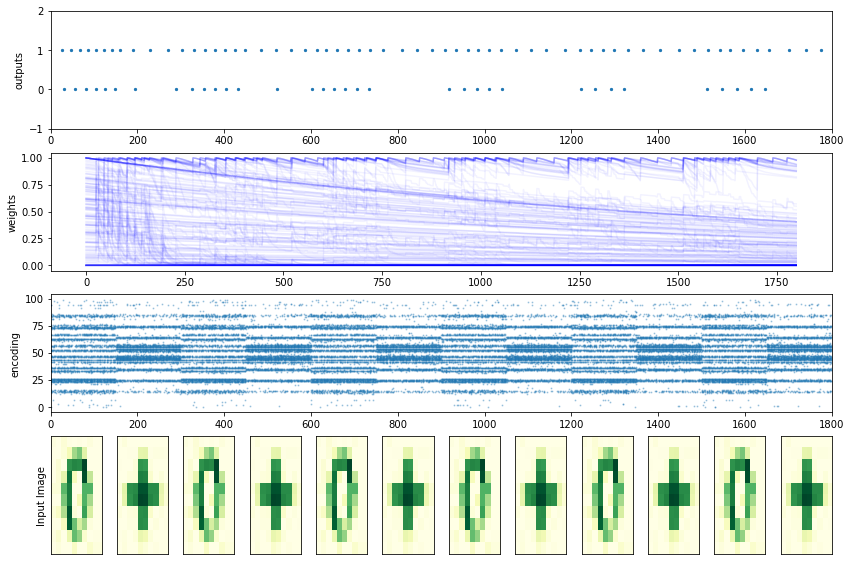

In [4]:
plt.figure(figsize=(14,10))
p = Plotter([
    ['output']*steps,
    ['weights']*steps,
    ['encode']*steps,
    [f'im{i}' for i in range(steps)],
], monitor=monitor, wspace=0.3)
for i in range(steps):
    y_label = "Input Image" if i==0 else ""
    p.imshow(f'im{i}', ims[i%2==0], y_label=y_label, cmap='YlGn', interpolation='nearest')
p.population_activity_raster('encode', y='encoder_spikes', y_label='encoding', alpha=.3)
p.population_plot('weights', y='w', y_label="weights", monitor=dendrite_monitor, aggregation=None,
                  population_alpha=.05)
p.population_activity_raster('output', y='output_spikes', y_label='outputs', s=5, y_lim=(-1,2))
p.show()

Limited Flat STDP

In [5]:
net = Network(dt=1.)
net += PoissonEncoder('encoder', shape=im1.shape, max_input=255)
net += LIFPopulation('output', (2,))
net += (
    SimpleSynapseSet(connectivity=dense_connectivity())
) |FROM| (
    SimpleAxonSet(scale=5)
    |OF| net['encoder']
) |TO| (
    SimpleDendriteSet(w=norm_initialization(w_std=.5))
    |OF| net['output']
) |FOLLOWING| (
    SimpleWeightDecayLRE(decay=0.001) +\
    FlatSTDP(
         pre_time=20.,
         post_time=20.,
         ltp_wdlr=stdp_wdlr(.1),
         ltd_wdlr=stdp_wdlr(.1)
        )
)
net.reset()
print(net)

======================================== Neural Populations:
 [encoder] encoder_axon_0
output_dendrite_0 [output] 
======================================== Synapse Sets:
encoder_axon_0 -> encoder_axon_0-output_dendrite_0 -> output_dendrite_0
======================================== Learning Rule Enforcers:
encoder_axon_0-output_dendrite_0_LRE, Combination of:
	encoder_axon_0-output_dendrite_0_LRE on: encoder_axon_0 -> encoder_axon_0-output_dendrite_0 -> output_dendrite_0
	encoder_axon_0-output_dendrite_0_LRE on: encoder_axon_0 -> encoder_axon_0-output_dendrite_0 -> output_dendrite_0

======================================== Neuromodulatory Tissues:



In [6]:
time = 150
steps = 12

monitor = Monitor(net, state_calls={
    'encoder_spikes': net['encoder'].spikes,
    'output_spikes': net['output'].spikes,
}, time=time)
dendrite_monitor = Monitor(net[[['encoder_axon_0-output_dendrite_0']]].dendrite, state_variables=['w'])
monitor.reset(), dendrite_monitor.reset()

net.reset()
ims = [im1,im2]
for i in range(steps):
    net['encoder'].encode(ims[i%2==0])
    monitor.simulate(net.run, attendance=[dendrite_monitor], reset=False)

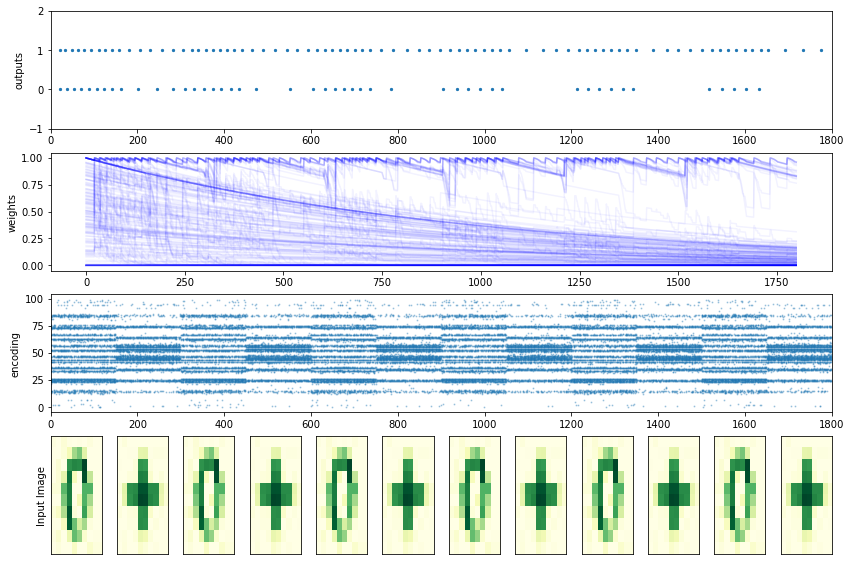

In [7]:
plt.figure(figsize=(14,10))
p = Plotter([
    ['output']*steps,
    ['weights']*steps,
    ['encode']*steps,
    [f'im{i}' for i in range(steps)],
], monitor=monitor, wspace=0.3)
for i in range(steps):
    y_label = "Input Image" if i==0 else ""
    p.imshow(f'im{i}', ims[i%2==0], y_label=y_label, cmap='YlGn', interpolation='nearest')
p.population_activity_raster('encode', y='encoder_spikes', y_label='encoding', alpha=.3)
p.population_plot('weights', y='w', y_label="weights", monitor=dendrite_monitor, aggregation=None,
                  population_alpha=.05)
p.population_activity_raster('output', y='output_spikes', y_label='outputs', s=5, y_lim=(-1,2))
p.show()

Flat STDP

In [21]:
net = Network(dt=1.)
net += PoissonEncoder('encoder', shape=im1.shape, max_input=255)
net += LIFPopulation('output', (2,))
net += (
    SimpleSynapseSet(connectivity=dense_connectivity())
) |FROM| (
    SimpleAxonSet(scale=5)
    |OF| net['encoder']
) |TO| (
    SimpleDendriteSet(w=norm_initialization(w_std=.5))
    |OF| net['output']
) |FOLLOWING| (
    SimpleWeightDecayLRE(decay=0.001) +\
    FlatSTDP(
         ltp_wdlr=stdp_wdlr(.1),
         ltd_wdlr=stdp_wdlr(.1)
        )
)
net.reset()
print(net)

======================================== Neural Populations:
 [encoder] encoder_axon_0
output_dendrite_0 [output] 
======================================== Synapse Sets:
encoder_axon_0 -> encoder_axon_0-output_dendrite_0 -> output_dendrite_0
======================================== Learning Rule Enforcers:
encoder_axon_0-output_dendrite_0_LRE, Combination of:
	encoder_axon_0-output_dendrite_0_LRE on: encoder_axon_0 -> encoder_axon_0-output_dendrite_0 -> output_dendrite_0
	encoder_axon_0-output_dendrite_0_LRE on: encoder_axon_0 -> encoder_axon_0-output_dendrite_0 -> output_dendrite_0

======================================== Neuromodulatory Tissues:



In [22]:
time = 150
steps = 12

monitor = Monitor(net, state_calls={
    'encoder_spikes': net['encoder'].spikes,
    'output_spikes': net['output'].spikes,
}, time=time)
dendrite_monitor = Monitor(net[[['encoder_axon_0-output_dendrite_0']]].dendrite, state_variables=['w'])
monitor.reset(), dendrite_monitor.reset()

net.reset()
ims = [im1,im2]
for i in range(steps):
    net['encoder'].encode(ims[i%2==0])
    monitor.simulate(net.run, attendance=[dendrite_monitor], reset=False)

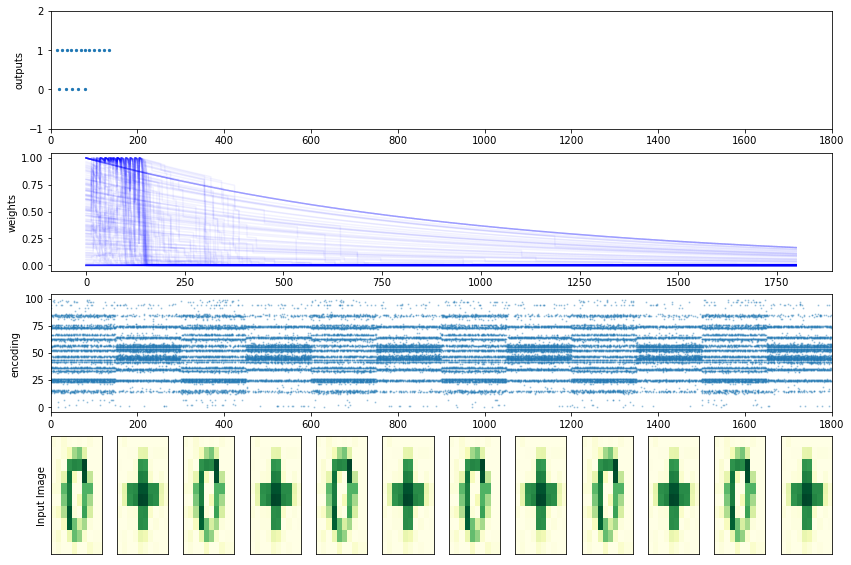

In [23]:
plt.figure(figsize=(14,10))
p = Plotter([
    ['output']*steps,
    ['weights']*steps,
    ['encode']*steps,
    [f'im{i}' for i in range(steps)],
], monitor=monitor, wspace=0.3)
for i in range(steps):
    y_label = "Input Image" if i==0 else ""
    p.imshow(f'im{i}', ims[i%2==0], y_label=y_label, cmap='YlGn', interpolation='nearest')
p.population_activity_raster('encode', y='encoder_spikes', y_label='encoding', alpha=.3)
p.population_plot('weights', y='w', y_label="weights", monitor=dendrite_monitor, aggregation=None,
                  population_alpha=.05)
p.population_activity_raster('output', y='output_spikes', y_label='outputs', s=5, y_lim=(-1,2))
p.show()

Supervised

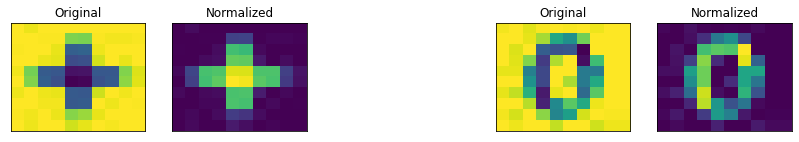

In [24]:
import warnings
warnings.filterwarnings("ignore")
import torch
import matplotlib.pyplot as plt
from cnsproject.network.network import Network
from cnsproject.network.network_wrapper import *
from cnsproject.network.neural_populations import LIFPopulation
from cnsproject.network.neuromodulatory_tissues import ImpulseDopaminergicTissue, SimpleDopaminergicTissue
from cnsproject.network.encoders import PoissonEncoder
from cnsproject.network.axon_sets import SimpleAxonSet
from cnsproject.network.dendrite_sets import SimpleDendriteSet
from cnsproject.network.synapse_sets import SimpleSynapseSet
from cnsproject.network.weight_initializations import norm_initialization
from cnsproject.network.connectivity_patterns import dense_connectivity
from cnsproject.learning.learning_rule_enforcers import STDP, FlatSTDP, SimpleWeightDecayLRE
from cnsproject.learning.learning_rule_enforcers import CentristWeightDecayLRE, RSTDP, FlatRSTDP
from cnsproject.learning.learning_rates import stdp_wdlr, constant_wdlr
from cnsproject.learning.synaptic_taggers import STDPST, FSTDPST
from cnsproject.monitors.monitors import Monitor
from cnsproject.monitors.plotter import Plotter
from PIL import Image
import numpy as np

path1 = "+.jpg"
path2 = "o.jpg"

plt.figure(figsize=(14,2))
p = Plotter([
    ['im1','nim1',None,'im2','nim2'],
])
p.imshow('im1', Image.open(path1).convert('L'), title="Original")
p.imshow('im2', Image.open(path2).convert('L'), title="Original")

def normalize(path):
    im = np.array(Image.open(path).convert('L'))
    im = torch.from_numpy(im)
    im = 255 - im
    im = im.float()
    im /= im.float().sum()
    im -= im.min()
    im /= im.max()
    im *= 255
    return im

im1,im2 = normalize(path1),normalize(path2)
p.imshow('nim1', Image.fromarray(im1.byte().numpy()), title="Normalized")
p.imshow('nim2', Image.fromarray(im2.byte().numpy()), title="Normalized")
plt.show()

In [25]:
def plot_every_thing(monitor, dendrite_monitor, predictions, steps = 8, name = ''):
    ims = [im1,im2]
    plt.figure(figsize=(14,14))
    p = Plotter([
        [f'pr{i}' for i in range(steps)],
        ['output']*steps,
        ['weights']*steps,
        ['dopamine']*steps,
        ['encode']*steps,
        [f'im{i}' for i in range(steps)],
    ], monitor=monitor, wspace=0.3)
    for i in range(steps):
        y_label = "Input Image" if i==0 else ""
        p.imshow(f'im{i}', ims[i%2==0], y_label=y_label, cmap='YlGn', interpolation='nearest')
        y_label = "Predicted Image" if i==0 else ""
        p.imshow(f'pr{i}', predictions[i], y_label=y_label, cmap='YlGn', interpolation='nearest')
    p.population_activity_raster('encode', y='encoder_spikes', y_label='encoding', alpha=.3, x_lim='fit')
    p.population_plot('weights', y='w', y_label="weights", monitor=dendrite_monitor, aggregation=None,
                      population_alpha=.05, x_lim='fit')
    p.plot('dopamine', y='dopamine', y_label="dopamine", x_lim='fit')
    p.population_activity_raster('output', y='output_spikes', y_label='outputs', s=5, y_lim=(-1,2),
                                 x_lim='fit', title=name)
    p.show()

In [26]:
def simulate(net, step_time = 50, step_count = 50):
    net.reset()
    monitor = Monitor(net, state_calls={
        'encoder_spikes': net['encoder'].spikes,
        'output_spikes': net['output'].spikes,
        'dopamine': net[['dopaminergic-tissue']].activity,
    }, time=step_time)
    dendrite_monitor = Monitor(net[[['synapse']]].dendrite, state_variables=['w'])
    monitor.reset(), dendrite_monitor.reset()
    net.reset()
    ims = [im1,im2]
    predictions = []
    for i in range(step_count):
        def run(expected, **args):
            if len(monitor['output_spikes'])>9:
                avtivities = monitor['output_spikes'][-10]
                y0, y1 = avtivities
                y0, y1 = int(y0), int(y1)
                reward = 0
                if expected==-1:
                    reward -= y0+y1
                elif expected==0:
                    reward += 2*y0-y1-.01
                elif expected==1:
                    reward += 2*y1-y0-.01
                net[['dopaminergic-tissue']].feedback(reward)
            net.run(**args)
        net['encoder'].encode(ims[i%2])
        monitor.simulate(run, inputs={"expected": [i%2]}, attendance=[dendrite_monitor], reset=False)
        avtivities = monitor['output_spikes'][-step_time:].sum(axis=0)
        predictions.append(ims[avtivities.argmax()])
        net['encoder'].encode(im1*0)
        monitor.simulate(run,
                         inputs={"encoder_clamp": torch.rand(int(step_time//3), *net['encoder'].output_shape)>.98,
                                "expected": [-1]},
                         attendance=[dendrite_monitor],
                         time=int(step_time//3), reset=False)
    return monitor,dendrite_monitor,predictions

In [27]:
net = Network(dt=1.)
net += PoissonEncoder('encoder', shape=im1.shape, max_input=255), LIFPopulation('output', (2,))
net += SimpleDopaminergicTissue('dopaminergic-tissue', tau=10.)
net += (
    SimpleSynapseSet('synapse', connectivity=dense_connectivity())
) |FROM| (
    SimpleAxonSet(scale=10)
    |OF| net['encoder']
) |TO| (
    SimpleDendriteSet(w=norm_initialization(w_std=.5))
    |OF| net['output']
) |FOLLOWING| (
    (
        SimpleWeightDecayLRE(decay=0.0001) + 
        RSTDP(
            stdp = STDP(
                pre_traces=STDPST(tau=350., scale=1.),
                post_traces=STDPST(tau=350., scale=1.),
                ltp_wdlr=stdp_wdlr(.1),
                ltd_wdlr=stdp_wdlr(.1)
            ),
        )
    ) |AFFECTED_BY| (
        SimpleAxonSet(scale=.005)
        |OF| net[['dopaminergic-tissue']]
    )
)
net.reset()
print(net)

======================================== Neural Populations:
 [encoder] encoder_axon_0
output_dendrite_0 [output] 
======================================== Synapse Sets:
encoder_axon_0 -> synapse -> output_dendrite_0
======================================== Learning Rule Enforcers:
synapse_LRE, Combination of:
	synapse_LRE on: encoder_axon_0 -> synapse -> output_dendrite_0
	synapse_LRE on: encoder_axon_0 -> synapse -> output_dendrite_0
		affected by: dopaminergic-tissue_axon_0

======================================== Neuromodulatory Tissues:
[dopaminergic-tissue] dopaminergic-tissue_axon_0



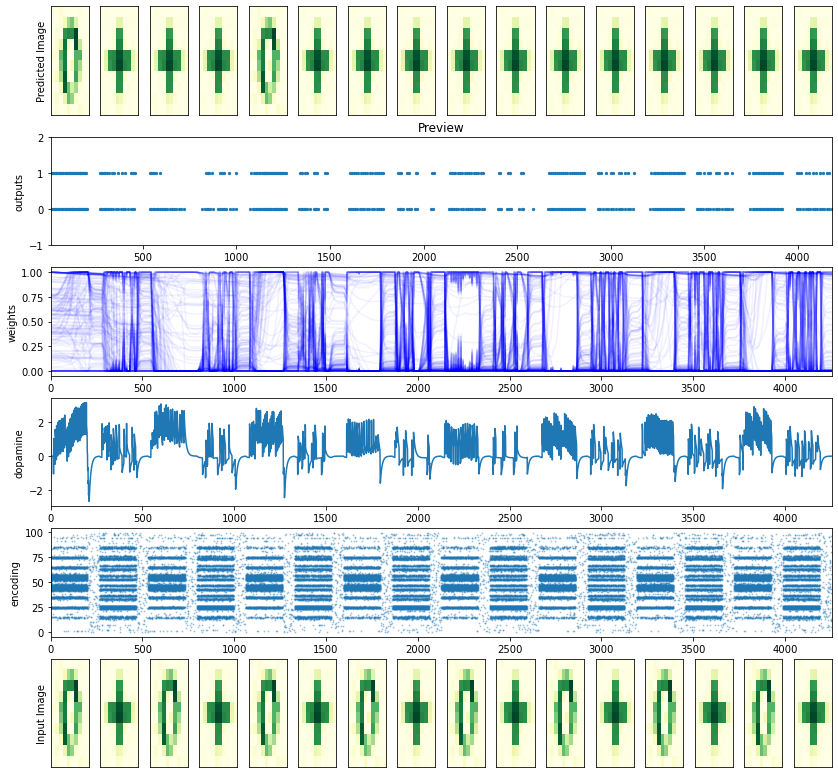

In [28]:
step_time = 200
step_count = 16
result = simulate(net, step_time=step_time, step_count=step_count)
plot_every_thing(*result,name='Preview', steps=step_count)

Flat

In [29]:
from cnsproject.learning.learning_rule_enforcers import CentristWeightDecayLRE, RSTDP, FlatRSTDP
from cnsproject.network.neuromodulatory_tissues import FlatDopaminergicTissue

net = Network(dt=1.)
net += PoissonEncoder('encoder', shape=im1.shape, max_input=255)
net += LIFPopulation('output', (2,))
net += FlatDopaminergicTissue('dopaminergic-tissue', time_window=20)
net += (
    SimpleSynapseSet('synapse', connectivity=dense_connectivity())
) |FROM| (
    SimpleAxonSet(scale=10)
    |OF| net['encoder']
) |TO| (
    SimpleDendriteSet(w=norm_initialization(w_std=.5))
    |OF| net['output']
) |FOLLOWING| (
    (
        SimpleWeightDecayLRE(decay=0.0001) + 
        FlatRSTDP(
            stdp = FlatSTDP(
                pre_time=20, post_time=20,
                ltp_wdlr=stdp_wdlr(.1),
                ltd_wdlr=stdp_wdlr(.1)
            ),
        )
    ) |AFFECTED_BY| (
        SimpleAxonSet(scale=1.5)
        |OF| net[['dopaminergic-tissue']]
    )
)
net.reset()
print(net)

======================================== Neural Populations:
 [encoder] encoder_axon_0
output_dendrite_0 [output] 
======================================== Synapse Sets:
encoder_axon_0 -> synapse -> output_dendrite_0
======================================== Learning Rule Enforcers:
synapse_LRE, Combination of:
	synapse_LRE on: encoder_axon_0 -> synapse -> output_dendrite_0
	synapse_LRE on: encoder_axon_0 -> synapse -> output_dendrite_0
		affected by: dopaminergic-tissue_axon_0

======================================== Neuromodulatory Tissues:
[dopaminergic-tissue] dopaminergic-tissue_axon_0



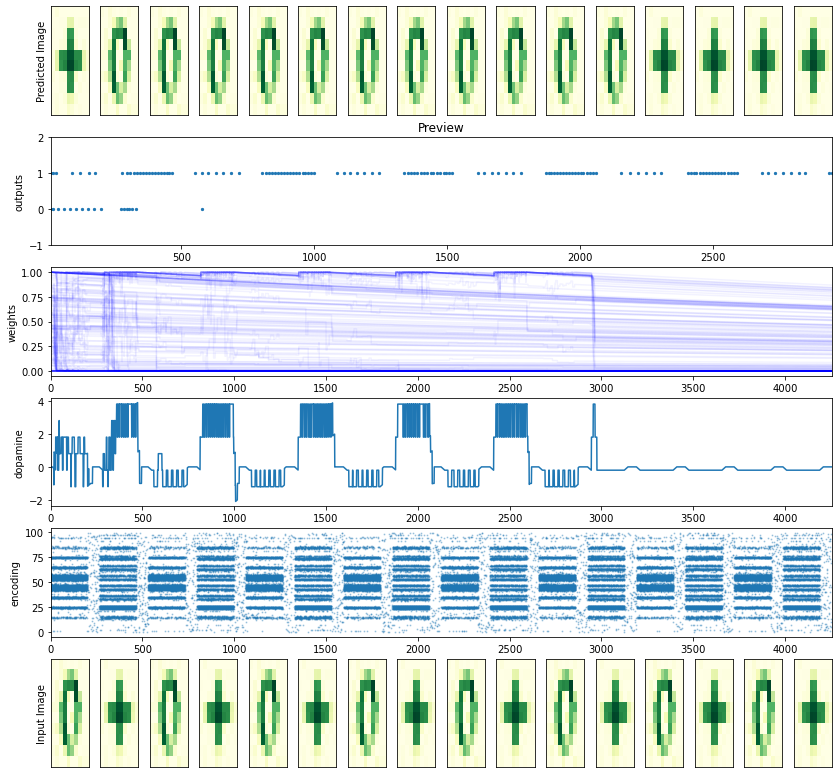

In [30]:
step_time = 200
step_count = 16
monitors = simulate(net, step_time=step_time, step_count=step_count)
plot_every_thing(*monitors,name='Preview', steps=step_count)

# ConvolutionalDendriteSet

In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
pi = torch.acos(torch.zeros(1)).item() * 2
path1 = "image1.jpg"

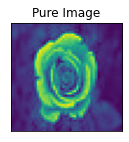

In [2]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter
from PIL import Image
import numpy as np

plt.figure(figsize=(2,2))
p = Plotter([['im1']])
im1 = np.array(Image.open(path1).convert('L'))
gr_im1= Image.fromarray(im1)
p.imshow('im1', gr_im1, title="Pure Image")
p.show()
im1 = torch.from_numpy(im1)

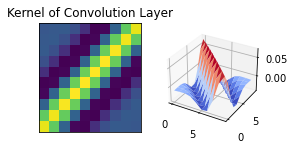

In [3]:
from cnsproject.network.kernels import gabor_kernel
from matplotlib import cm

def kernel(kernel_size):
    return gabor_kernel(
        kernel_size=kernel_size,
        wavelength=6,
        std=2,
        aspect_ratio=.1,
        orientation=torch.tensor(pi/4),
    )

plt.figure(figsize=(4,2))
p = Plotter([['kernel','kernel3D']])
p.imshow('kernel', kernel(10), title="Kernel of Convolution Layer")
p.surface_3d('kernel3D', data={'z': kernel(10)}, cmap=cm.coolwarm)
p.show()

In [4]:
from torchvision import transforms
from cnsproject.network.filters import Conv2DFilter,CoreCentricFilter

norm = transforms.Normalize(.5,.5)
default_conv = Conv2DFilter(kernel=kernel(7), stride=2, padding=3, transform=norm)
default_pooling = CoreCentricFilter(core=torch.nn.MaxPool2d(kernel_size=4, stride=2), transform=norm)

In [7]:
from cnsproject.network.network import Network
from cnsproject.network.network_wrapper import *
from cnsproject.network.neural_populations import LIFPopulation
from cnsproject.network.synapse_sets import LazySynapseSet
from cnsproject.network.axon_sets import SimpleAxonSet
from cnsproject.network.dendrite_sets import FilteringDendriteSet2D
from cnsproject.network.encoders import PoissonEncoder
from cnsproject.monitors.monitors import Monitor

time = 20
dt=1
def simulate(p, conv_layer=default_conv, pooling_layer=default_pooling, encoder=PoissonEncoder,
             time=time, name='', postfix='', title=True, axon_scale=500):
    net = Network(dt=1.)
    if encoder is PoissonEncoder:
        net += encoder('encoder', shape=im1.shape, max_input=255)
    else:
        net += encoder('encoder', shape=im1.shape, max_input=255, time=time)
    net += LazySynapseSet('conv') |FROM| (SimpleAxonSet(scale=axon_scale) |OF| net['encoder']) |TO| \
        FilteringDendriteSet2D(filt=conv_layer)
    net += LIFPopulation('conv_output', net[[['conv']]].dendrite.required_population_shape()) \
        |USING| net[[['conv']]].dendrite
    net += LazySynapseSet('pool') |FROM| (SimpleAxonSet(scale=500) |OF| net['conv_output']) |TO| \
        FilteringDendriteSet2D(filt=pooling_layer)
    net += LIFPopulation('pool_output', net[[['pool']]].dendrite.required_population_shape()) \
        |USING| net[[['pool']]].dendrite
    net.reset()

    monitor = Monitor(net, state_calls={
        'encoder_spikes': net['encoder'].spikes,
        'conv_output_spikes': net['conv_output'].spikes,
        'pool_output_spikes': net['pool_output'].spikes,
    }, time=time)
    monitor.reset()
    net.reset()
    net['encoder'].encode(im1)
    monitor.simulate(net.run, reset=False)

    p.monitor = monitor
    p.imshow('im'+postfix, im1, title="Input Image" if title else '', cmap='YlGn', interpolation='nearest',
            y_label=name)
    p.population_activity_raster('encode'+postfix, y='encoder_spikes', alpha=.1, y_label=None, y_vis=False,
                                 title='encoder_spikes' if title else '', x_vis=False)
    p.imshow('encode_im'+postfix, net['encoder'].decode(monitor['encoder_spikes']),
             title='encoded image' if title else '', cmap='YlGn', interpolation='nearest')
    p.population_activity_raster('conv'+postfix, y='conv_output_spikes', y_label=None, y_vis=False,
                                 title='conv_output_spikes' if title else '', x_vis=False)
    conv_im = PoissonEncoder('temp', shape=monitor['conv_output_spikes'][0].shape, max_input=255)\
                 .decode(monitor['conv_output_spikes'])
    p.imshow('conv_im'+postfix, conv_im, title='conv image' if title else '', cmap='YlGn', interpolation='nearest')
    p.population_activity_raster('pool'+postfix, y='pool_output_spikes', y_label=None, y_vis=False, 
                                 title='pool_output_spikes' if title else '', x_vis=False)
    pool_im = PoissonEncoder('temp'+postfix, shape=monitor['pool_output_spikes'][0].shape, max_input=255)\
                 .decode(monitor['pool_output_spikes'])
    p.imshow('pool_im'+postfix, pool_im, title='pool image' if title else '', cmap='YlGn', interpolation='nearest')
    return net
    
plot_line = lambda postfix: [x+str(postfix) for x in ['im','encode','encode_im','conv','conv_im','pool','pool_im']]

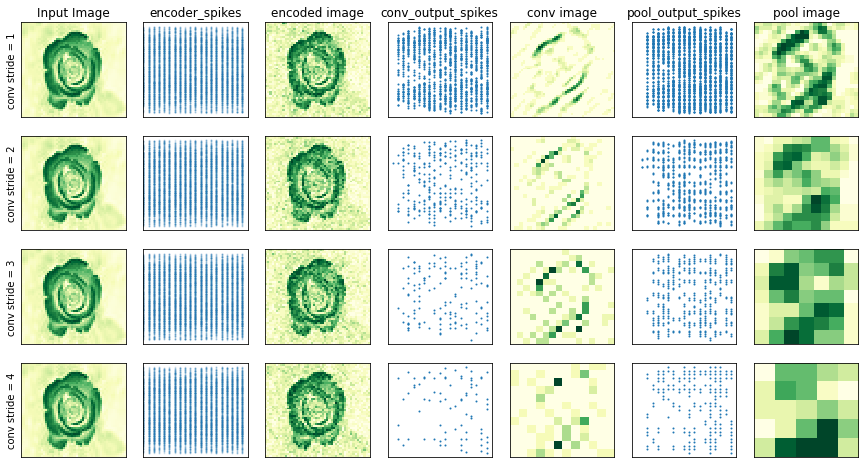

In [8]:
i_max = 4
plt.figure(figsize=(15,2*i_max))
p = Plotter([plot_line(i) for i in range(i_max)], wspace=0.17, hspace=0.2)
for i in range(i_max):
    net = simulate(p, conv_layer=Conv2DFilter(kernel=kernel(7), stride=i+1, padding=3, transform=norm),
             postfix=str(i), title=i==0, name=f'conv stride = {i+1}')
p.show()

# DisposablePopulationProxy

In [2]:
from cnsproject.network.neural_populations import LIFPopulation,DisposablePopulationProxy
n = DisposablePopulationProxy(LIFPopulation('n1', (10,), dt=1))

/home/behzad/Documents/CNS/cns-project-template/cnsproject/network/neural_populations.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.dt = torch.tensor(dt) if dt is not None else dt


In [3]:
from cnsproject.utils import generate_function
I = generate_function(50, shape=(10,),
           shift={0: 75, 75: 50},
           noise=10,
           population_noise=5)

In [4]:
from cnsproject.monitors.monitors import Monitor
m = Monitor(n, ['s'])
m.simulate(n.forward, inputs={'direct_input': I}, time=50)
n.reset()
m.simulate(n.forward, inputs={'direct_input': I}, time=50, reset=False)

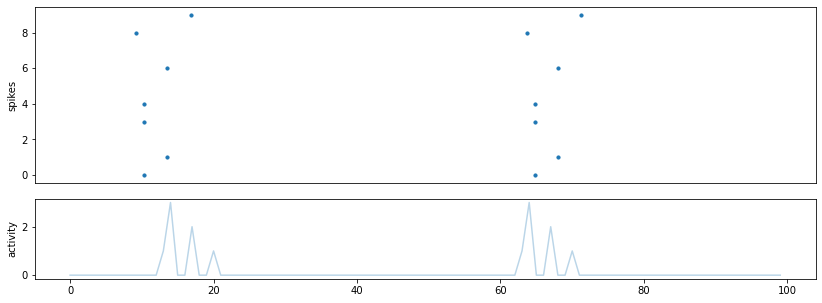

In [5]:
import matplotlib.pyplot as plt
from cnsproject.monitors.plotter import Plotter

plt.figure(figsize=(14,5))
p = Plotter([
    ['s'],
    ['s'],
    ['a'],
], wspace=0.3, monitor=m)
p.population_activity_raster('s', x_vis=False, s=10)
p.population_activity('a')
p.show()